# Esercitazione 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

obs=[
    "ene",
    "heat",
    "chi",
    "mag"
]

## 1 Modello di Ising

Il modello di Ising è un modello della meccanica statistica utilizzato per studiare diversi sistemi, ad esempio la magnetizzazione di un ferro magnete.  Consiste in un sistema di spin $N$-dimensionale descritto da  un'*Hamiltoniana*, con donizioni periodiche, quindi $s_{N+1}=s_1$.  Noi studieremo il caso monodimensionale, quindi l'*Hamiltoniana* diventa:
$$
H=-J\sum_{i=1}^N s_i\,s_{i+1}-\frac{h}{2}\sum_{i=1}^N(s_i+s_{i+1})
$$

Essendo un sistema ferromagnetico i valori di $s_i\in\{-1,1\}$ e $J>0$. 

Per semplificare poniamo:
- $k_B=1$ .
- $\mu_B=1$ .

Nel nostro caso possiamo trovare analiticamente la soluzione per la funzione dei partizione $Z$:
$$
Z=\sum_{\{s_i\}}(-\beta\,H)=\lambda_1^N+\lambda_2^N
$$
con $\lambda_{1,2} = e^{\beta J} \cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$ e $\beta=\frac{1}{k_B\,T}$.

Da $Z$ possiamo ricavare l'*energia libera di Gibbs*:
$$
A=-k_B\,T\ln{Z}
$$

Da queste possiamo ricavare tutte le altre grandezze termodinamiche.

### 1.1 Algoritmi di Campionamento

Per trovare la funzione di partizione serve trovare un algoritmo per campionare lo spazio degli stati.  Non ne useremo due:
1. Metropolis.
2. Gibbs.

#### 1.1.1 Algoritmo di Metropolis

L'__algoritmo di Metropolis__ consiste in prendere un campione e cambiare il suo stato ed accettare la "*mossa*" in base alla probabilità $q(x|y)=\min[1,A(x|y)]$, dove:
$$
A(x|y)=\frac{T(x|y)\,p(x)}{T(y|x)\,p(y)}
$$
con $T(x|y)$ la probabilità che il sistema passi da $x$ a $y$ e $p(x)$ la probabilità di trovarsi in $x$.

La comodità di questo algoritmo è che non serve che le probabilità siano normalizzate.

Nel __modello di Ising__ selezioniamo casualmente uno spin e lo giriamo ($\pm 1 \to \mp 1$) con probabilità $q(\Delta E)=\min{\left[1,e^{-\beta\,\Delta E}\right]}$.

#### 1.1.2 Algoritmo di Gibbs

L'__algoritmo di Gibbs__ preso un sistema con più variabili cambiamo lo stato di una di queste variabili mantenedole tutte costanti tranne una la quale, il nuovo stato, viene estratto dalla probabilità condizionale dello stato attuale rispetto agli altri.

In questo caso le mosse vengono sempre accettate, ma neanche con __Gibbs__ c'è bisogno di sapere la funzione di partizione.

Nel __modello di Ising__ estrarremo le mosse dalla probabilità:
$$
p(s_k'=\pm1|\{s_j:j\neq k\})=\frac{1}{1+exp(-\beta\,\Delta E_{s_k=\pm1\to s_k=\mp1})}
$$

### 1.2 Simulazione

Utilizzando questi algoritmi possiamo campionare lo spazio degli stati per determinare le grandezze termodinamiche:
1. Energia interna: $U(N,T) = \langle H \rangle_{h=0}$
2. Capacità termica: $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. Sucettibilità magnetica: $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. Magnetizzazione: $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

Confronteremo questi vaolri con quelli ottenuti analiticamente nel range di $T\in[0.5,2]$.

<font color=red>N.B.</font> Anche in questa esercitazione è necessaria la termalizzazione del sistema, per velocizzare questo processo inizieremo con una configurazione casuale alla temperatura più alta per poi abbassare la temperatura ripartendo dall'ultima configurazione della temperatura precedente.

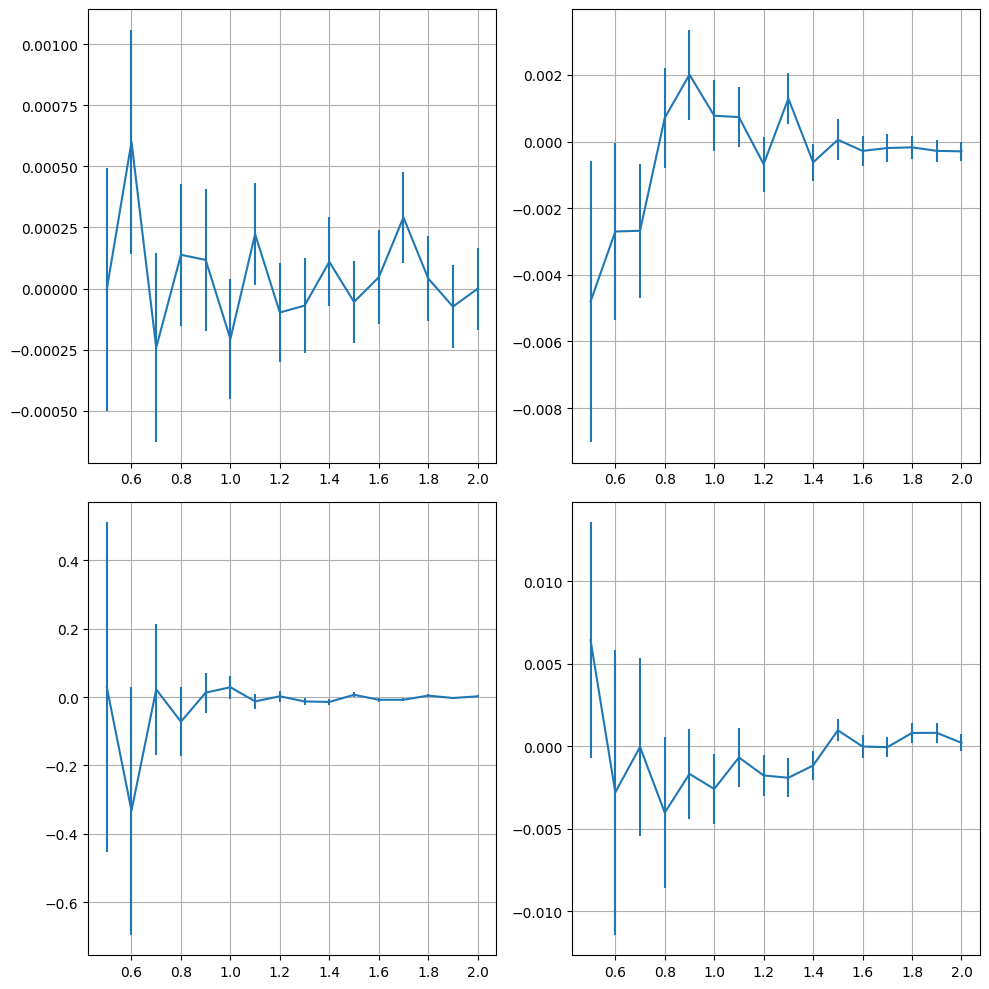

In [18]:
N=16
T=np.linspace(0.5,2,N)

beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th

e = -J*( th + ch*thN )/( 1 + thN )
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

appo=[e,heat,X,M]

fig, ax=plt.subplots(2,2,figsize=(10,10))
ax=np.reshape(ax,4)

for j in range(4):
    
    data=np.array([np.loadtxt("ISING_1D/output_"+obs[j]+"_"+ str(np.round(T[i],1)) +".dat") for i in range(N)])

    ax[j].errorbar(T,data[:,-1,2]-appo[j],yerr=data[:,-1,3])
    #ax[j].plot(T,appo[j])
    
    #Parte estetica
    ax[j].grid(True)

#ax[-1].axis('off')

plt.tight_layout()
plt.show()


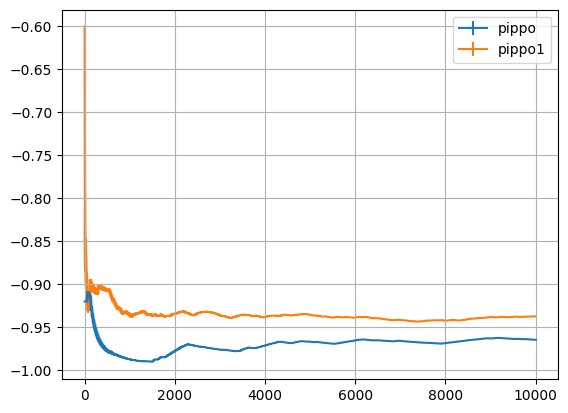

In [39]:
data=np.loadtxt("ISING_1D/lippo.dat")
plt.errorbar(data[:,0],data[:,2],yerr=data[:,3],label="pippo",zorder=2)
data=np.loadtxt("ISING_1D/pippo.dat")
plt.errorbar(data[:,0],data[:,2],yerr=data[:,3],label="pippo1",zorder=1)
plt.grid()
plt.legend()
plt.show()